In [3]:
# try:
#   # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
from tensorflow import keras

from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, Rescaling
from keras.losses import SparseCategoricalCrossentropy


import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".

# train = os.walk(train_dir)
# val = os.walk(validation_dir)
test = os.listdir(test_dir)

total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# train
# val
# test

In [6]:
# 3
train_image_generator = None
validation_image_generator = None
test_image_generator = None

train_data_gen = utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123, 
    batch_size=batch_size, 
    image_size=(IMG_HEIGHT, IMG_WIDTH))

val_data_gen = utils.image_dataset_from_directory(
    validation_dir,
    validation_split=0.2,
    subset='validation',
    seed=123, 
    batch_size=batch_size, 
    image_size=(IMG_HEIGHT, IMG_WIDTH))

# test_data_gen = utils.image_dataset_from_directory(
#     test_dir,
#     seed=123, 
#     batch_size=batch_size, 
#     image_size=(IMG_HEIGHT, IMG_WIDTH))

class_names = train_data_gen.class_names

AUTOTUNE = tf.data.AUTOTUNE

train_data_gen = train_data_gen.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data_gen = val_data_gen.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = Rescaling(1./255)
normalized_ds = train_data_gen.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [28]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip(images_arr, axes):
          ax.imshow(img.astype('uint8'))
          # print(type(img))
        #   ax.imshow(img.numpy().astype("uint8"))
          ax.axis('off')
    else:
      for img, probability, ax in zip(images_arr, probabilities, axes):
          ax.imshow(img.astype('uint8'))
          # print(type(img))
        #   ax.imshow(img.numpy().astype("uint8"))
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

# check = train_data_gen.take(1)

# sample_training_images, _ = next(iter(train_data_gen.take(1)))
# print(sample_training_images)
# plotImages(sample_training_images[:5])

# print(train_data_gen)
# plt.figure(figsize=(10, 10))
# for images, labels in train_data_gen.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")


In [8]:
# 5
train_image_generator = None

data_augmentation = Sequential(
  [ 
    RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT,
                                  IMG_WIDTH,
                                  3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)


c:\Users\Furqon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


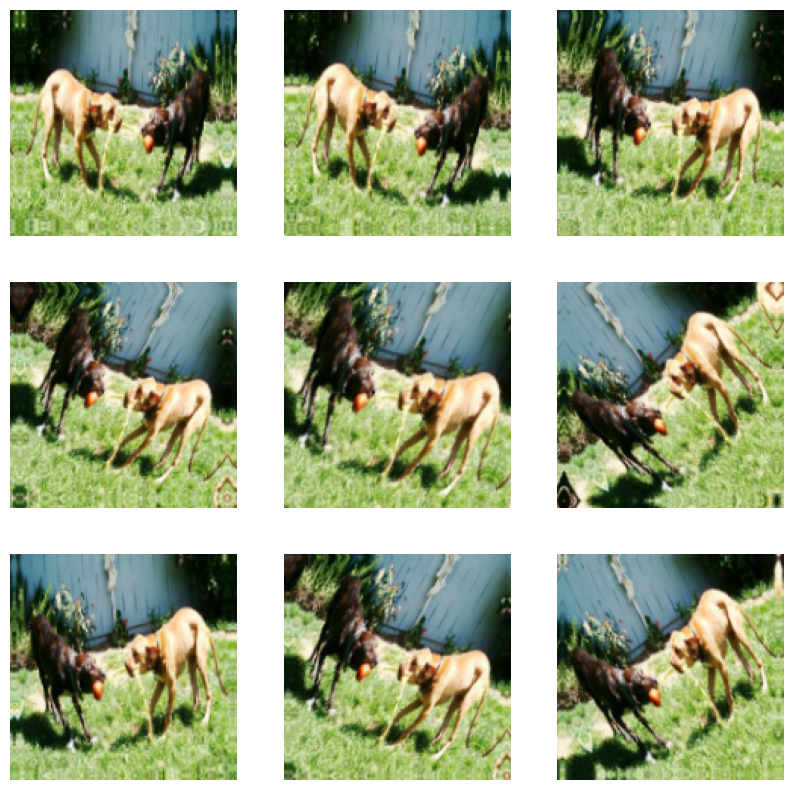

In [9]:
# 6
# train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
#                                                      directory=train_dir,
#                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                      class_mode='binary')

# augmented_images = [train_data_gen[0][0][0] for i in range(5)]

# plotImages(augmented_images)

plt.figure(figsize=(10, 10))
for images, _ in train_data_gen.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
# 7
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH,3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes),
    ])

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,678,178 (10.22 MB)

 Trainable params: 2,678,178 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 8
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=epochs
)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.5125 - loss: 0.7503 - val_accuracy: 0.4350 - val_loss: 0.7070
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - accuracy: 0.5138 - loss: 0.6846 - val_accuracy: 0.5150 - val_loss: 0.6831
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accuracy: 0.6069 - loss: 0.6538 - val_accuracy: 0.5750 - val_loss: 0.6714
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.6263 - loss: 0.6363 - val_accuracy: 0.6850 - val_loss: 0.6139
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 690ms/step - accuracy: 0.6637 - loss: 0.6176 - val_accuracy: 0.7300 - val_loss: 0.5822
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - accuracy: 0.6787 - loss: 0.5901 - val_accuracy: 0.6800 - val_loss: 0.6135
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - accuracy: 0.6975 - loss: 0.5839 - val_accuracy: 0.7250 - val_loss: 0.5855
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.7088 - loss: 0.5590 - val_accuracy: 0.

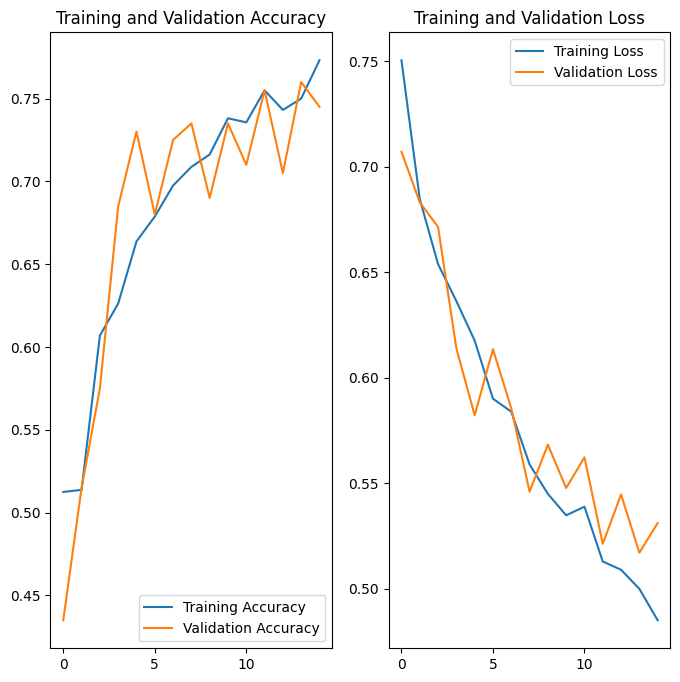

In [12]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
probabilities = list()
test_image = list()
# plt.imshow(plt.imread(PATH+'\\test\\'+test[1]))

for img_path in test[1:]:
    img = utils.load_img(
        PATH+'\\test\\'+img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = utils.img_to_array(img)
    # test_image.append(plt.imread(PATH+'\\test\\'+img_path))
    test_image.append(img_array)

    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    probabilities.append(np.float32(score[1]))

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
# print(probabilities)
# print(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
This image most likely belongs to dogs with a 75.40 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
This image most likely belongs to cats with a 83.07 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
This image most likely belongs to cats with a 94.88 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
This image most likely belongs to dogs with a 91.36 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
This image most likely belongs to dogs with a 64.60 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
This image most likely belongs to cats with a 50.59 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
This image most likely belongs to cats with a 69.87 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
This image most likely belongs to cats with a 86.41 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
This image most likely belongs to dogs with a 76.41 percent confidence.
1/1 ━━━━━

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

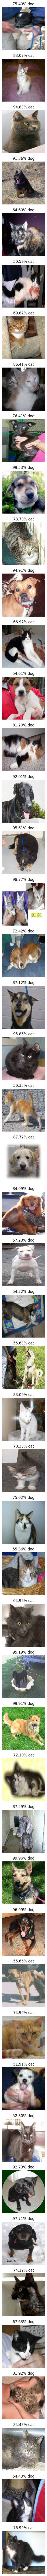

In [27]:
# print(test_image)
# print(probabilities)
plotImages(test_image, probabilities)

In [29]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
